# Time Series Synchronization

Find out how time delay affects the MAP-rSO2 plot. See if the signals can be synchronized using cross correlation.

Simo Mäkelä  
Helsinki Metropolia University of Applied Sciences  
4.10.2020

In [376]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

from utils import zoll
from utils import nirs
from utils import misc
from utils.autoscale import autoscale

In [377]:
# parameters
case_id = 1

In [378]:
case_str = str(case_id).zfill(5)
datafile = 'output/' + case_str + '_3.csv'

In [379]:
# load data
df = pd.read_csv(datafile,
                 sep = ',',
                 na_values = ['-'],
                 parse_dates = ['Time'])
misc.NormalizeTime(df)
df.set_index('Time', inplace=True)
mark_timestamp = df.loc[df['Mark'] == 1].index[0]

In [380]:
# load manually defined timeshifts
shift_df = pd.read_csv('amend/timeshift.csv', sep = ',')
manual_shift = shift_df.loc[shift_df['Case'] == case_id]['MAP_shift'].iloc[0]

In [381]:
# dropout
df['rSO2'] = np.where(df['Bad_rSO2_manual'] == 1, np.nan, df['rSO2'])
df['MAP'] = np.where(df['Bad_MAP_auto'] == 1, np.nan, df['MAP'])
df['MAP'] = np.where(df['Bad_MAP_manual'] == 1, np.nan, df['MAP'])

In [382]:
# smooth rSO2 to match MAP
df['rSO2'] = df['rSO2'].rolling(10).mean()

In [383]:
x = np.arange(-500, 500)
cross = [df['rSO2'].corr(df['MAP'].shift(lag)) for lag in x]
shift = x[np.argmax(np.abs(cross))]
print("Optimal time shift: {} seconds".format(shift))

Optimal time shift: -467 seconds


[&lt;matplotlib.lines.Line2D at 0x17e6a070940&gt;]

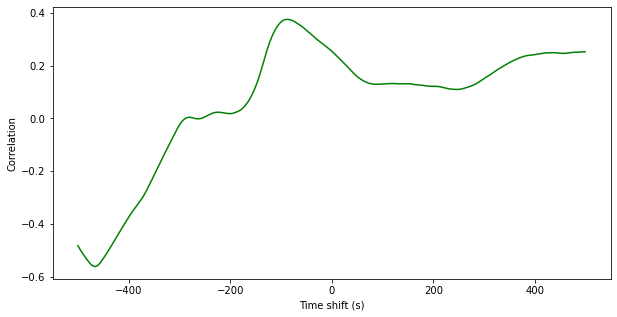

In [384]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_xlabel('Time shift (s)')
ax.set_ylabel('Correlation')
plt.plot(x, cross, c='green')

In [385]:
# resampling as per Ono, Joshi, Brady, Easley et al. 2012
df['MAP_resampled'] = df['MAP'].resample('10s').mean()
df['rSO2_resampled'] = df['rSO2'].resample('10s').mean()

In [386]:
def PlotTimeline(shift, title):
    fig, ax1 = plt.subplots(figsize=(20,6))
    ax1.set_ylabel('rSO2', color='navy')
    line1 = ax1.plot(df.index, df['rSO2'], color='navy', label='rSO2')
    ax1.tick_params(axis='y', labelcolor='navy')
    ax2 = ax1.twinx()
    ax2.xaxis.set_major_formatter(mpl.dates.DateFormatter('%H:%M'))
    ax2.set_ylabel('MAP', color='maroon')
    line2 = ax2.plot(df.index, df['MAP'].shift(shift), color='maroon', label='MAP')
    ax2.tick_params(axis='y', labelcolor='maroon')
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    plt.legend(lines, labels, loc='upper left')
    ax2.grid()
    plt.title(title)
    ax1.axvline(mark_timestamp, linestyle='--', linewidth=3)
    plt.autoscale(enable=True, axis="x", tight=True)
    plt.show()

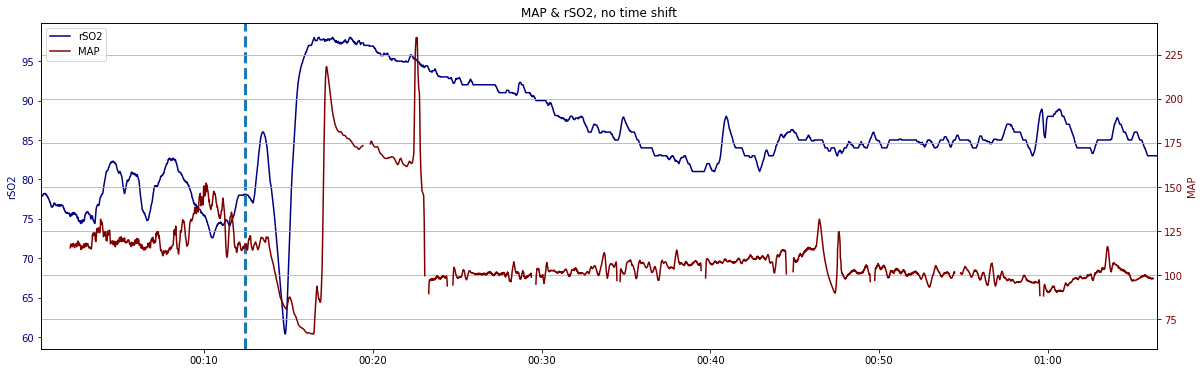

In [387]:
PlotTimeline(0, 'MAP & rSO2, no time shift')

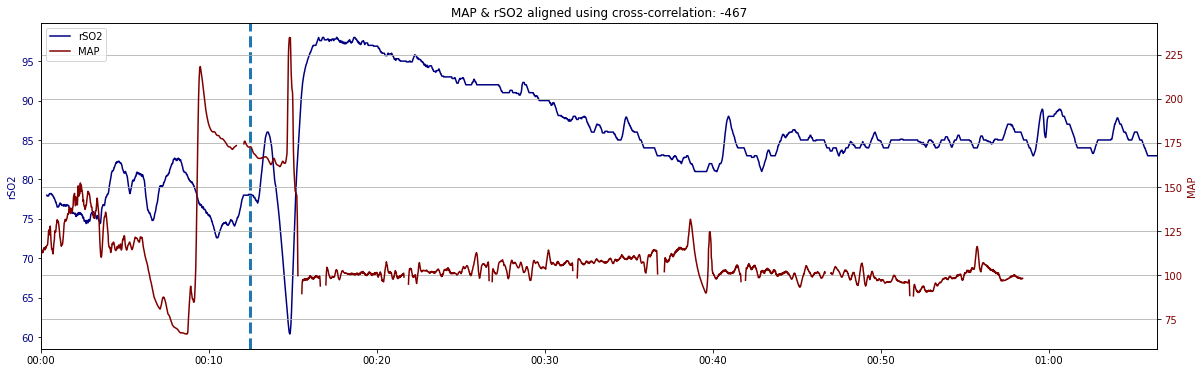

In [388]:
PlotTimeline(shift, 'MAP & rSO2 aligned using cross-correlation: ' + str(shift))

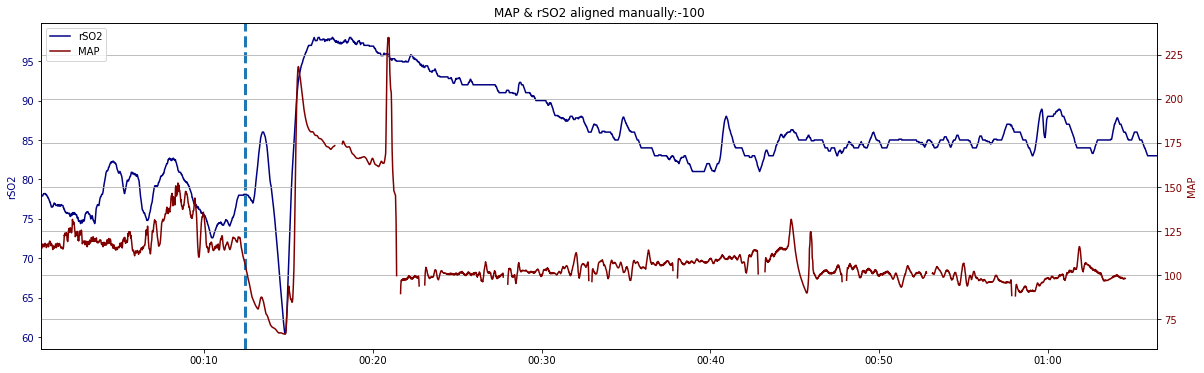

In [389]:
PlotTimeline(manual_shift, 'MAP & rSO2 aligned manually:' + str(manual_shift))

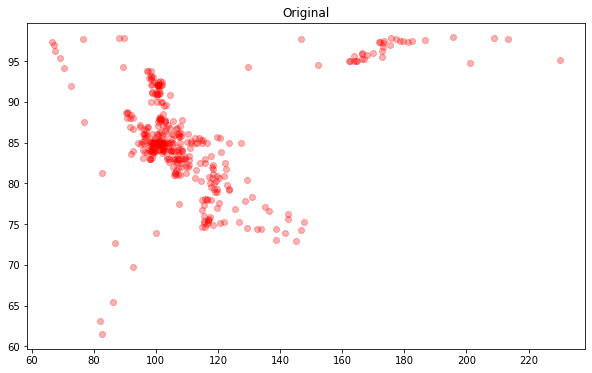

In [390]:
fig, ax = plt.subplots(figsize=(10,6))
plt.scatter(df['MAP_resampled'], df['rSO2_resampled'], alpha=0.3, c='r')
plt.title('Original')
plt.show()

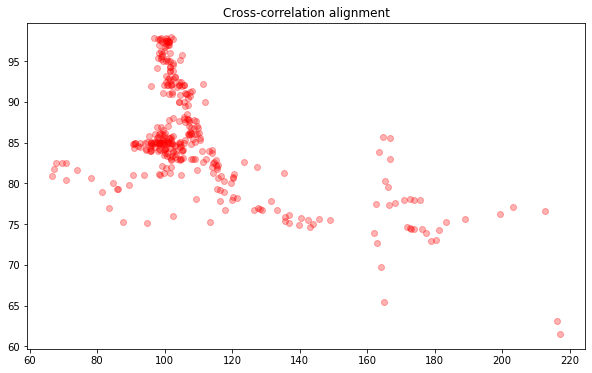

In [391]:
df['MAP_shifted'] = df['MAP'].shift(shift)
df['MAP_resampled_s'] = df['MAP_shifted'].resample('10s').mean()

fig, ax = plt.subplots(figsize=(10,6))
plt.scatter(df['MAP_resampled_s'], df['rSO2_resampled'], alpha=0.3, c='r')
plt.title('Cross-correlation alignment')
plt.show()

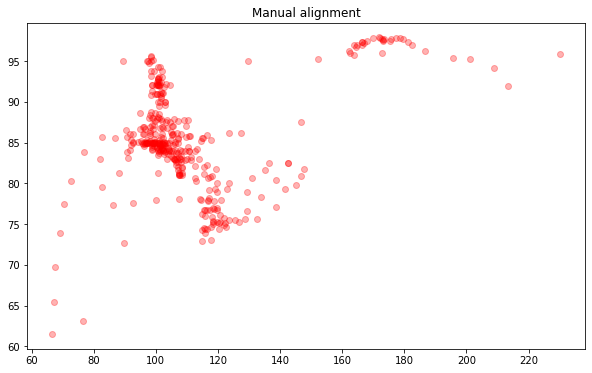

In [392]:
df['MAP_shifted'] = df['MAP'].shift(manual_shift)
df['MAP_resampled_s'] = df['MAP_shifted'].resample('10s').mean()

fig, ax = plt.subplots(figsize=(10,6))
plt.scatter(df['MAP_resampled_s'], df['rSO2_resampled'], alpha=0.3, c='r')
plt.title('Manual alignment')
plt.show()